# Cтратегия взаимодействия с клиентами для сети фитнес-центров

# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов.

На основе данных о посетителях сети фитнес-центров спрогнозировать вероятность оттока для каждого клиента в следующем месяце, сформировать с помощью кластеризации портреты пользователей

# Задачи проекта

* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента


* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства


* проанализировать основные признаки, наиболее сильно влияющие на отток


* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
      1) выделить целевые группы клиентов
      2) предложить меры по снижению оттока
      3) определить другие особенности взаимодействия с клиентами

# Описание данных

Набор данных включает следующие поля:
* `Churn` — факт оттока в текущем месяце

1. Данные клиента за предыдущий до проверки факта оттока месяц:

* `gender` — пол
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
* `Phone` — наличие контактного телефона
* `Age` — возраст
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)

2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год)
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)
* `Group_visits` — факт посещения групповых занятий
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон


## Импортирование библиотек

In [ ]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
# импортируем необходимые библиотеки для работы

In [ ]:
pd.set_option('display.max_colwidth', 1000) # для выводов всех символов в записях
sns.set_style('dark') # стиль графиков
sns.set_palette('pastel') # цветовая палитра
pd.options.display.float_format = '{:,.2f}'.format # округление чисел до 2 знаков после запятой
import warnings
warnings.filterwarnings('ignore') # игнорирование предупреждений

## Изучение общей информации

In [ ]:
df = pd.read_csv('/datasets/gym_churn.csv')
# чтение файла

In [ ]:
def first_look(df):
    display(df.head(10))
    print()
    print('Размер предоставленного датафрейма:', df.shape)
    print()
    display(df.info())
    print()
    display(df.describe())
    print()

first_look(df)
# функция для первичного изучения датафрейма

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0
5,1,1,0,0,1,1,1,34,450.74,1.00,3,2.62,2.64,0
6,1,1,1,1,0,6,1,32,94.27,6.00,2,1.14,1.28,0
7,0,1,0,0,1,1,0,30,217.79,1.00,0,1.21,1.05,1
8,1,1,1,1,1,1,1,23,45.41,1.00,1,1.11,1.06,0
9,0,1,0,0,1,1,0,31,65.31,1.00,11,1.81,1.95,0



Размер предоставленного датафрейма: (4000, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_cla

None

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Первое, что бросается в глаза, это название столбцов, сразу приведем их в "хороший формат". Столбец `month_to_end_contract` представлен в формате float, переведем в формат int. 

In [ ]:
df.columns = df.columns.str.lower()
df.columns
# столбцы в нижний регистр, проверка

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [ ]:
df['month_to_end_contract'].value_counts()
# посмотрим на уникальные значения, для того, чтобы убедиться, нет ли дробных чисел

1.00     2207
6.00      645
12.00     524
11.00     181
5.00      130
10.00      82
9.00       73
4.00       58
8.00       38
7.00       25
3.00       23
2.00       14
Name: month_to_end_contract, dtype: int64

In [ ]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')
# перевод в тип int

In [ ]:
df.isna().sum()
# посмотри на пропуски методом isna

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [ ]:
print('Количество дубликатов в таблице df =', df.duplicated().sum())
# проверим на дубликаты

Количество дубликатов в таблице df = 0


Проверим результат

In [ ]:
df.sample(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3037,0,1,0,0,1,1,0,31,131.50,1,1,0.85,0.83,0
1413,0,1,1,1,1,1,0,23,154.15,1,0,1.09,0.00,1
1295,1,0,1,1,1,1,0,31,310.33,1,1,1.51,1.44,0
3470,1,1,0,0,1,1,1,29,168.22,1,12,1.88,1.65,0
1591,0,1,0,0,1,6,0,30,143.85,6,1,0.85,0.87,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

### Вывод:

Датасет содержит 14 столбцов и 4000 записей. Пропусков и дубликатов нет. 
Привели название столбцов в нижний регистр и поменяли тип столбца `month_to_end_contract`.              

## Исследовательский анализ данных

###  Изучим средние значения и стандартные отклонения признаков

Примени метод describe() для каждого признака

In [ ]:
df['gender'].describe()

count   4,000.00
mean        0.51
std         0.50
min         0.00
25%         0.00
50%         1.00
75%         1.00
max         1.00
Name: gender, dtype: float64

Распределение по половому признаку 50 на 50. Стандартное отклонение 0,5.

In [ ]:
df['near_location'].describe()

count   4,000.00
mean        0.85
std         0.36
min         0.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: near_location, dtype: float64

85% клиентов проиживают или работают в районе, где находится фитнес-центр. Стандартное отклонение 0,36

In [ ]:
df['partner'].describe()                  

count   4,000.00
mean        0.49
std         0.50
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: partner, dtype: float64

49% клиентов - сотрудники компании-партнёра клуба. Стандартное отклонение 0,5

In [ ]:
df['promo_friends'].describe()

count   4,000.00
mean        0.31
std         0.46
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: promo_friends, dtype: float64

31% клиентов при покупке первого абонемента использовали промокод от знакомого (акция "приведи друга"). Стандратное отклонение 0,46

In [ ]:
df['phone'].describe()

count   4,000.00
mean        0.90
std         0.30
min         0.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: phone, dtype: float64

90% клиентов оставляют свой контактный телефон. Стандартное отклонение 0,3

In [ ]:
df['contract_period'].describe()

count   4,000.00
mean        4.68
std         4.55
min         1.00
25%         1.00
50%         1.00
75%         6.00
max        12.00
Name: contract_period, dtype: float64

Длительность абонемента есть трех видов: месяц, 6 месяцев и год. Среднее значение по нашим данным это 5 месяцев, однако медианное значение один месяц.

In [ ]:
df['group_visits'].describe()

count   4,000.00
mean        0.41
std         0.49
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: group_visits, dtype: float64

41% клиентов посещают групповые занятия. Стандартное отклонение 0,49

In [ ]:
df['age'].describe()

count   4,000.00
mean       29.18
std         3.26
min        18.00
25%        27.00
50%        29.00
75%        31.00
max        41.00
Name: age, dtype: float64

Возразтная группа клиентов фитнес-центра от 18 до 41. В среднем людям по 29 лет (медианное значение тоже 29).

In [ ]:
df['avg_additional_charges_total'].describe()

count   4,000.00
mean      146.94
std        96.36
min         0.15
25%        68.87
50%       136.22
75%       210.95
max       552.59
Name: avg_additional_charges_total, dtype: float64

Средняя суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон составляет 147 долларов. Максимальная выручка 552 доллара. Стандартное отклонение в 96 долларов.

In [ ]:
df['month_to_end_contract'].describe()

count   4,000.00
mean        4.32
std         4.19
min         1.00
25%         1.00
50%         1.00
75%         6.00
max        12.00
Name: month_to_end_contract, dtype: float64

Средний срок до окончания текущего действующего абонемента 4 месяца. Медианное значение 1 месяц. Скорее всего на среднее значение влияет годовой абонемент.

In [ ]:
df['lifetime'].describe()

count   4,000.00
mean        3.72
std         3.75
min         0.00
25%         1.00
50%         3.00
75%         5.00
max        31.00
Name: lifetime, dtype: float64

Среднее время с момента первого обращения в фитнес-центр 3 месяца. Максимальное значение 31 месяц, это почти три года.

In [ ]:
df['avg_class_frequency_total'].describe()

count   4,000.00
mean        1.88
std         0.97
min         0.00
25%         1.18
50%         1.83
75%         2.54
max         6.02
Name: avg_class_frequency_total, dtype: float64

Средняя частота посещений фитнес-центра в неделю за все время с начала действия абонемента составляет 1-2 раза. Максимальное количество песещений - 6. Стандартное отклонение 0,97

In [ ]:
df['avg_class_frequency_current_month'].describe()

count   4,000.00
mean        1.77
std         1.05
min         0.00
25%         0.96
50%         1.72
75%         2.51
max         6.15
Name: avg_class_frequency_current_month, dtype: float64

Средняя частота посещений фитнес-центра в неделю за предыдущий месяц составляет 1-2 раза. Максимальное - 6 посещений. Стандратное отклонение 1,05

In [ ]:
df['churn'].describe()

count   4,000.00
mean        0.27
std         0.44
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: churn, dtype: float64

За текущий месяц процент оттока состаил 27%. Стандартное отклонение 0,44

### Cредние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [ ]:
df.groupby('churn')['gender'].agg('count')
# посмотрим на количетсво клиентов

churn
0    2939
1    1061
Name: gender, dtype: int64

1061 клиент ушел в отток. Остались 2939 человек

In [ ]:
df.groupby('churn').agg('mean').T
# средние значения всех признаков 

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


**Вывод:**

* Пол и наличие контактного номера телефона никак не влияет на отток клиентов


* В отток уходят клиенты, которые проживают или работают рядом с фитнес-центром. 36% из них являются сотрудниками компаний-партнероа клуба. В среднем они посещяют клуб 1 раз в неделю и берут абонементы на месяц. Практически не посещают групповые занятия. Средний возраст клиентов, уходящих в отток 27 лет.

### Cтолбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

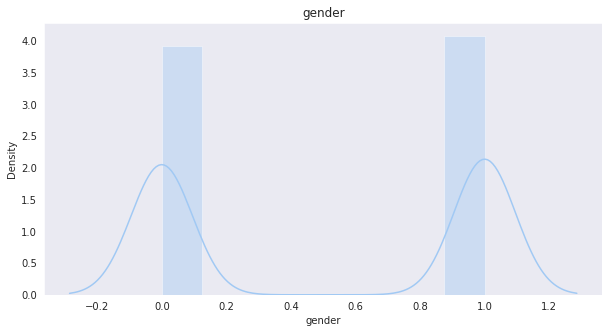

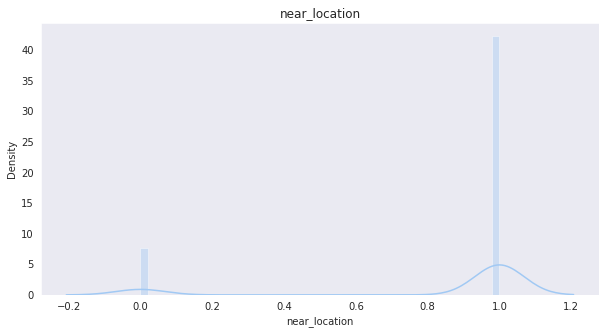

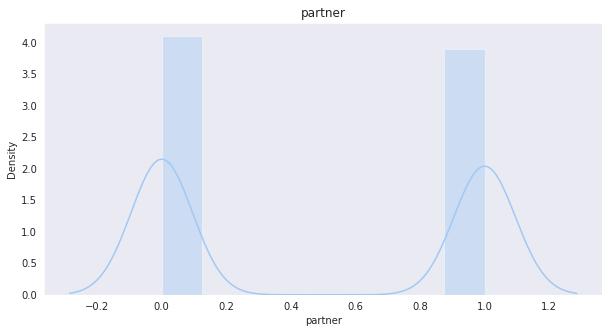

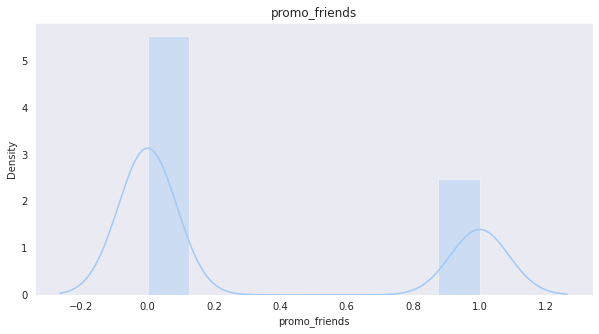

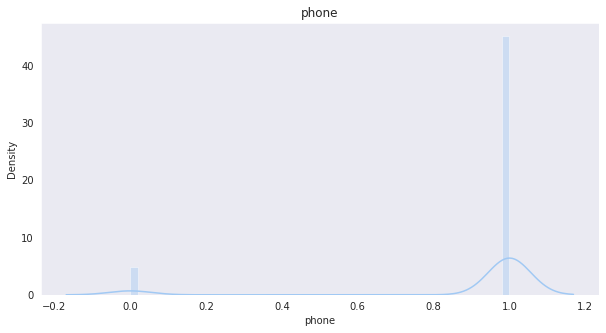

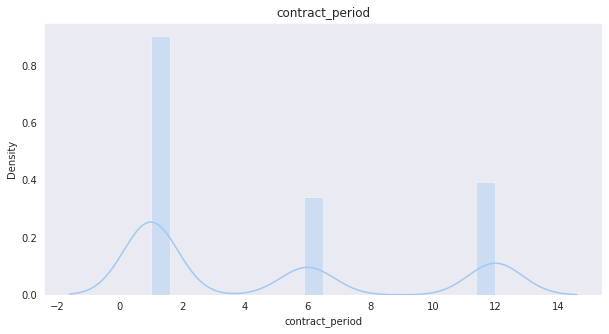

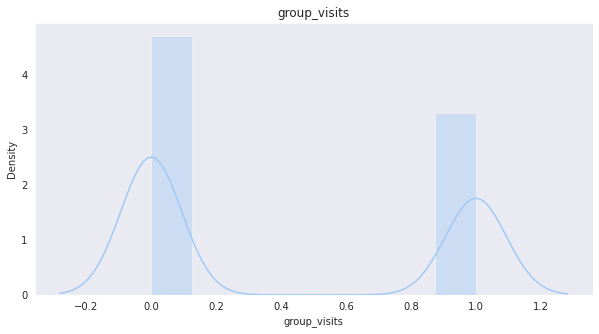

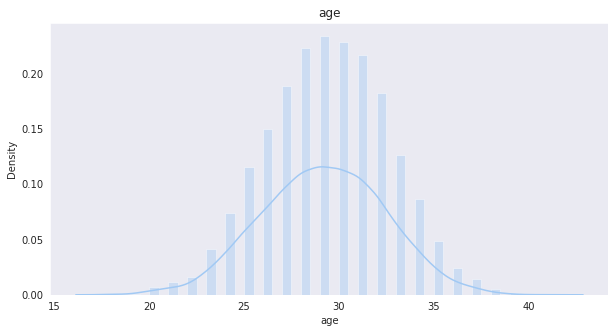

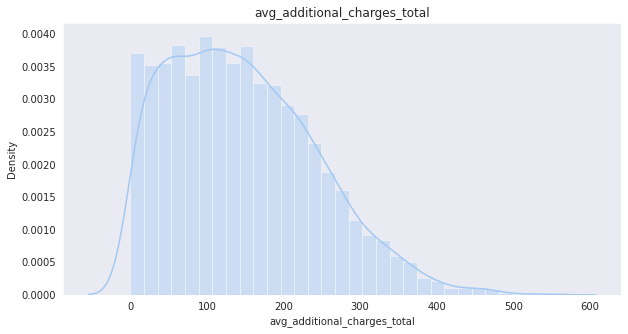

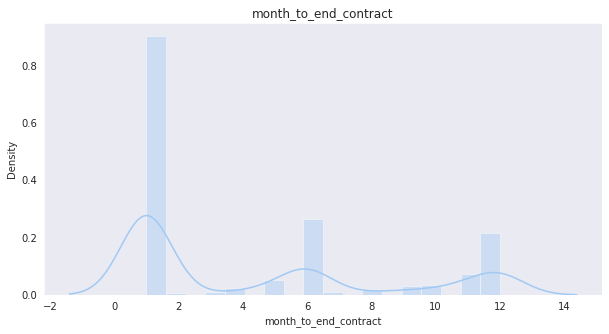

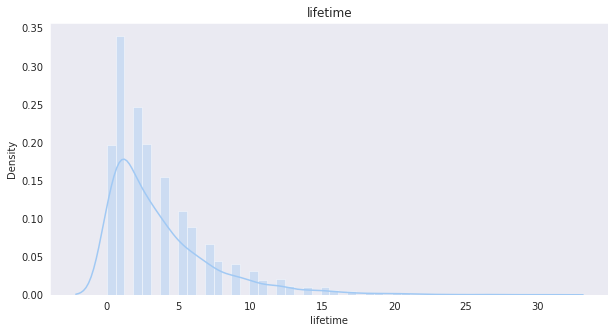

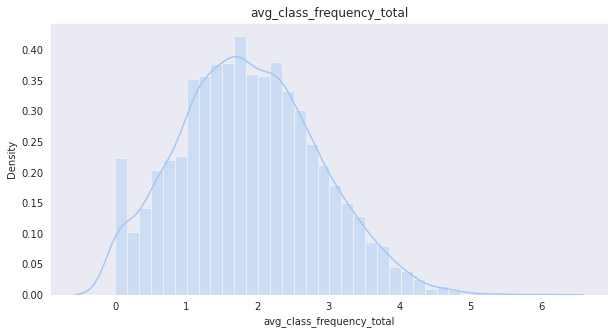

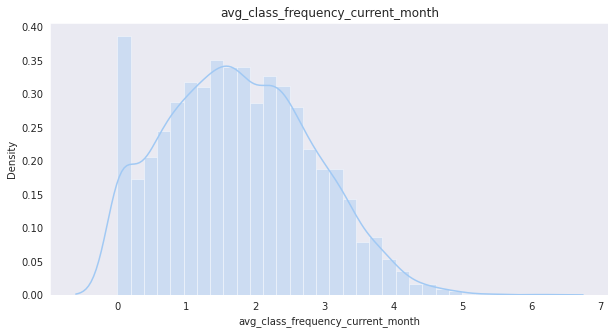

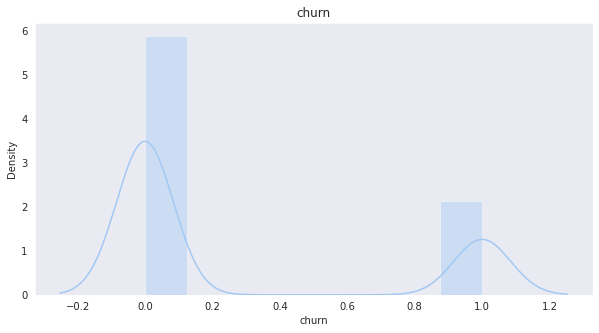

In [ ]:
for column in df.columns:
    plt.figure(figsize=(10, 5))
    df.groupby('churn')[column]
    sns.distplot(df[column])
    plt.title(column)
    plt.show()
# гистограммы для всех признаков    

Посмотрим на более интресные признаки детально

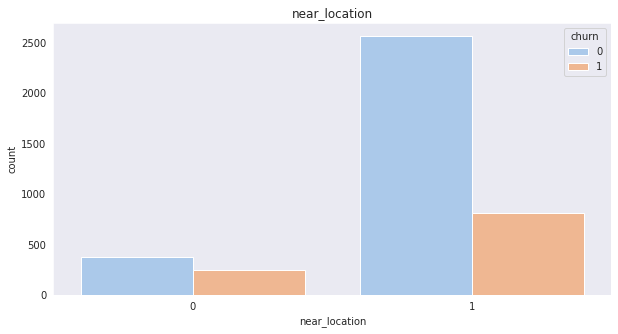

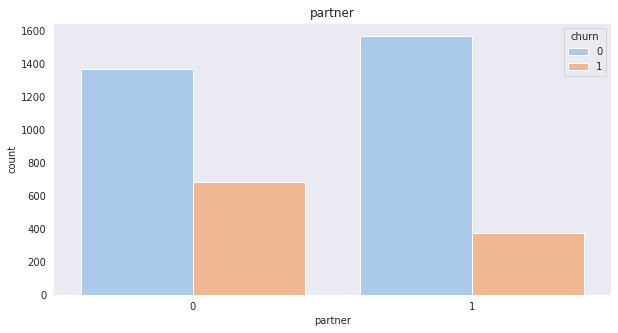

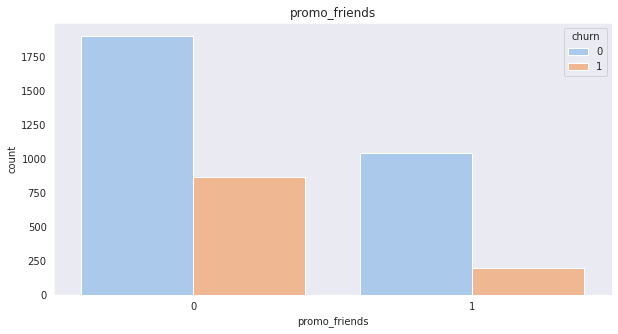

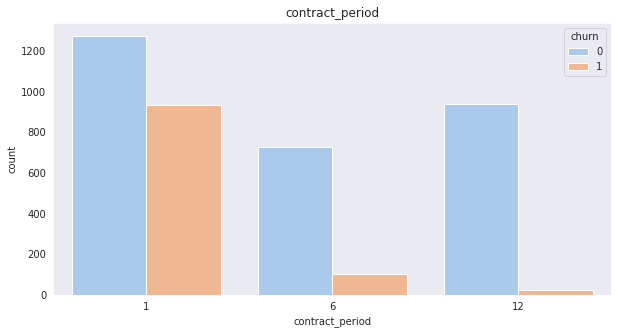

In [ ]:
for column in ['near_location', 'partner', \
               'promo_friends', 'contract_period']:
    plt.figure(figsize=(10,5))
    sns.countplot(x = df[column], hue='churn', data = df)
    plt.title(column)
    plt.show()

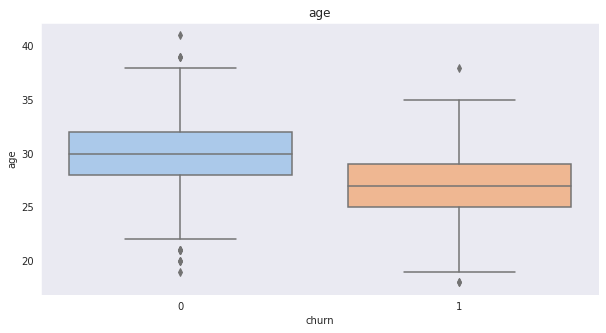

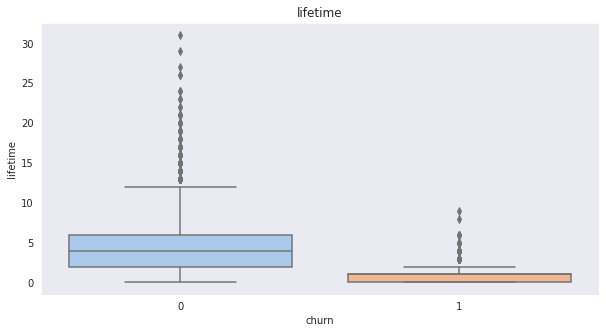

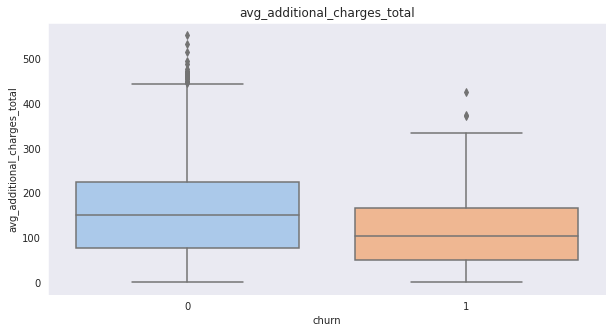

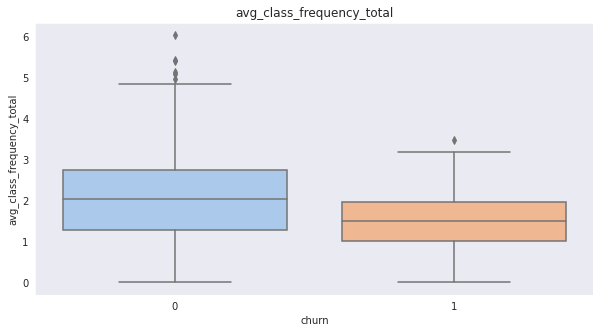

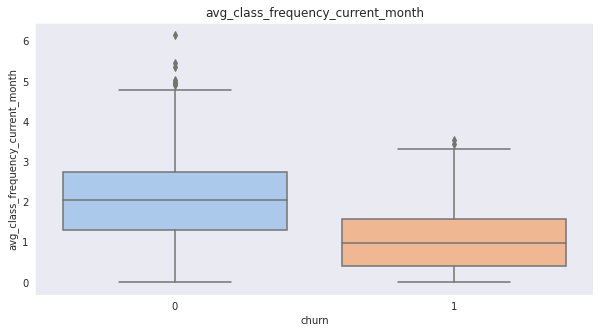

In [ ]:
for column in ['age', 'lifetime', 'avg_additional_charges_total', 'avg_class_frequency_total', \
               'avg_class_frequency_current_month']:
    plt.figure(figsize=(10,5))
    sns.boxplot(data = df, x = 'churn', y = df[column])
    plt.title(column)
    plt.show()

**Вывод:**

* Главные признаки, влияющие на отток клиентов это проживание или работа в районе, где находится фитнес центр и длительность абонемента. Клиенты с абонементом на 1 месяц чаще всего уходят в отток. 

### Матрица корреляций 

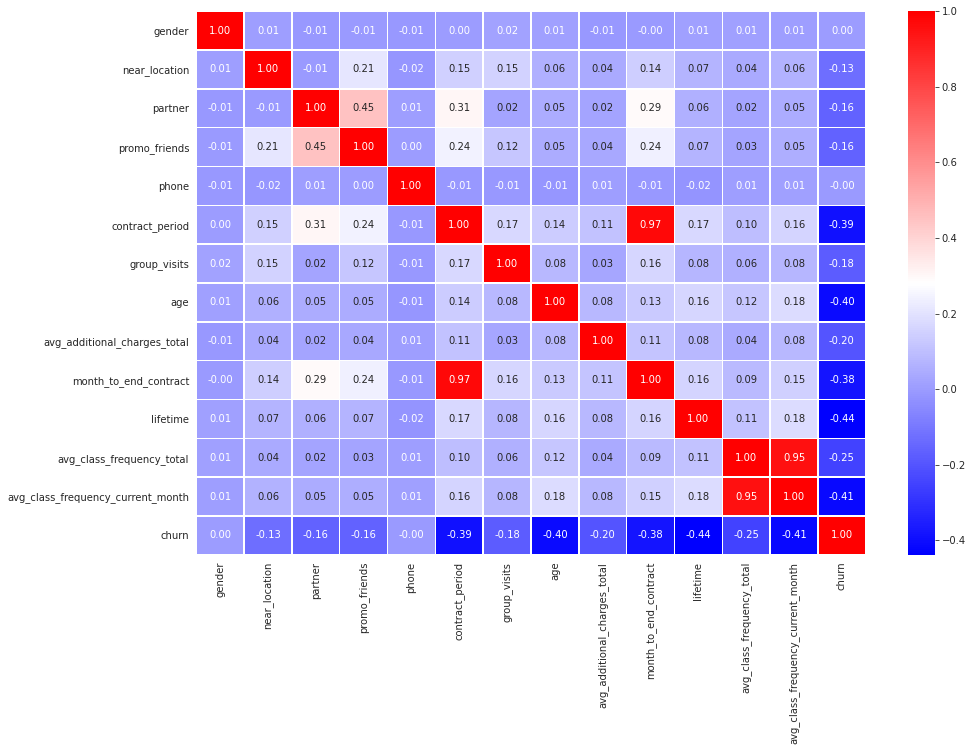

In [ ]:
corr_m = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_m, annot = True, fmt = '0.2f', linewidths=.5, cmap="bwr")
plt.show()

**Вывод:**

* Сильная корреляционная связь наблюдается между длительностью абонемента и сроком до окончания абонемента(0,97). Кроме того, видим сильную корреляционную связь между посещяемостью фитнес-центра в текущем месяце и за все время(0,95).


* Видим нулевые корреляционные связи - это пол и контактный номер с оттоком клиентов.

## Модель прогнозирования оттока клиентов

### Разобъем данные на обучающую и валидационную выборку функцией train_test_split()

In [ ]:
X = df.drop('churn', axis=1)
y = df['churn']
# разделим наши данные на признаки (матрица X) и целевую переменную (y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# разделяем модель на обучающую и валидационную выборку

### Обучим модель на train-выборке двумя способами: логистической регрессией, случайным лесом.

In [ ]:
models = [LogisticRegression(random_state=0), RandomForestClassifier(random_state=0)]
# зададим список моделей

In [ ]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
        )
    )
# функция, которая принимает на вход модель и данные и выводит метрики

### Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Какая модель показала себя лучше на основании метрик?

* Accuracy: доля правильных ответов
* Precision: точность
* Recall: полнота

In [ ]:
for i in models:
    print(i)
    make_prediction(
        m=i,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )
# цикл, который выводит метрики по списку моделей    

LogisticRegression(random_state=0)
Accuracy:0.91 Precision:0.82 Recall:0.80
RandomForestClassifier(random_state=0)
Accuracy:0.92 Precision:0.84 Recall:0.82


**Вывод:**

Модель случайного леса показала себя лучше по всем признакам. Доля правильных ответов: 91%, точность: 84%, полнота 82%.

##  Кластеризация клиентов

### Стандартизируем данные

In [ ]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
# обязательная стандартизация данных перед работой с алгоритмами

### Постром матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

In [ ]:
linked = linkage(X_sc, method = 'ward')
# таблица «связок» между объектами.

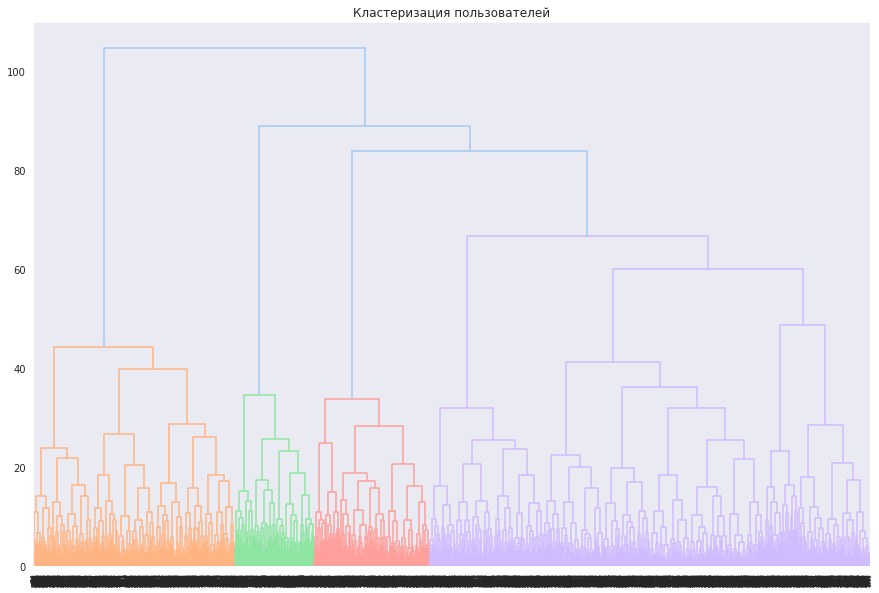

In [ ]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей')
plt.show()
# строим дендрограмму

На графике отчетливо видно 4 кластера. По условию проекта примем число кластеров равное 5.

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов

In [ ]:
km = KMeans(n_clusters=5, random_state=0) # задаём модель k_means с числом кластеров 5 и фиксируем значение random_state

labels = km.fit_predict(X_sc) # прогнозируем кластеры для наблюдений

### Посмотрим на средние значения признаков для кластеров

In [ ]:
df['cluster'] = labels
# сохраняем метки кластера в поле нашего датасета

In [ ]:
clusters = df.groupby(['cluster']).mean().T
clusters
# выводим статистику по средним значениям наших признаков по кластеру

cluster,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66
month_to_end_contract,9.95,4.48,2.20,1.86,2.46


In [ ]:
cluster_features = df.groupby('cluster').mean().reset_index()
cluster_features.T.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)

,0,1,2,3,4
cluster,0.00,1.00,2.00,3.00,4.00
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66


**Вывод:**

* Выделим два кластера с наибольшим оттоком клиентов: 2 и 3
* Для этих кластеров характерно: 
   - минимальное посещение групповых занятий
   - длительность абонемента 1-2 месяца
   - приходят без промокода
   - живут или работают рядом с фитнесом


* Самые надежные кластеры: 0 и 4
* Для этих кластеров характерно:
   - длительность абонемента больше 6 месяцев
   - являются сотрудниками компаний-партнеров
   - посещяют групповые занятия
   - посещяют фитнес 2-3 раза в неделю

### Построим распределения признаков для кластеров

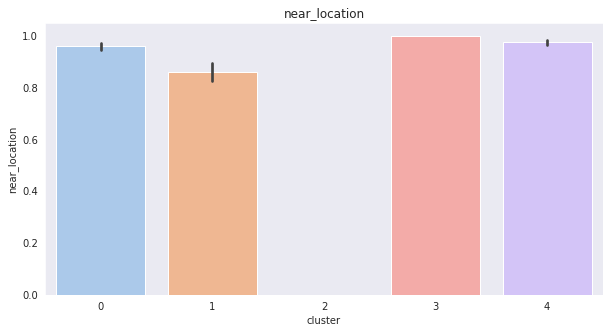

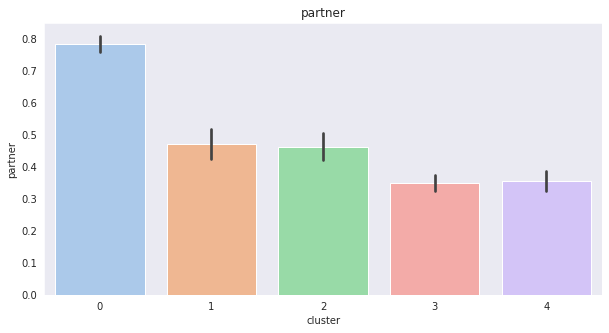

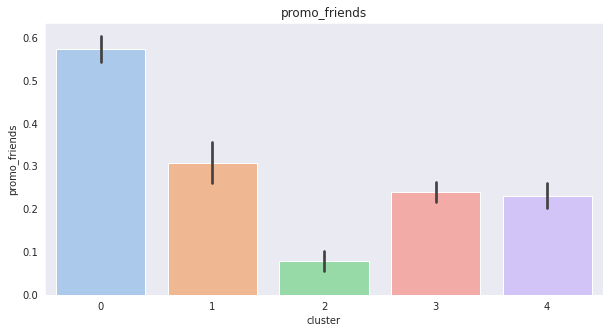

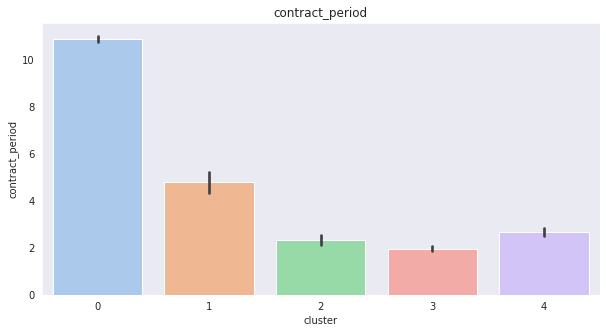

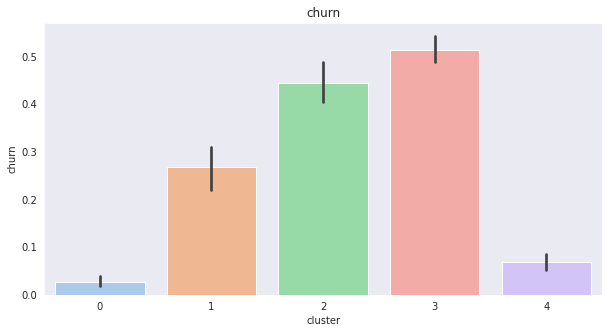

In [ ]:
for column in ['near_location', 'partner', 'promo_friends', 'contract_period', 'churn']:
    plt.figure(figsize=(10, 5))
    sns.barplot(x = 'cluster', y=column, data=df)
    plt.title(column)
    plt.show()

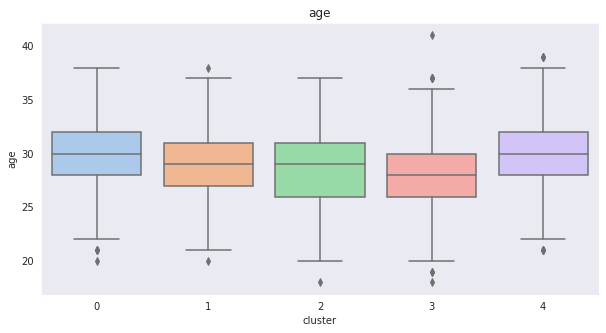

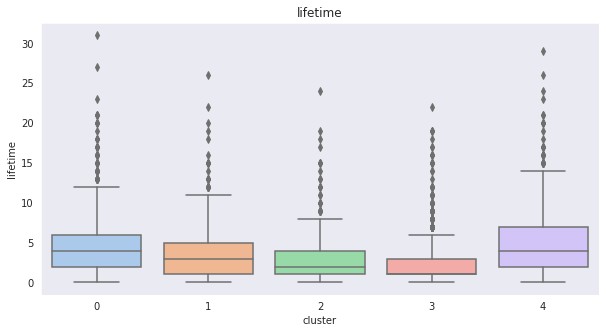

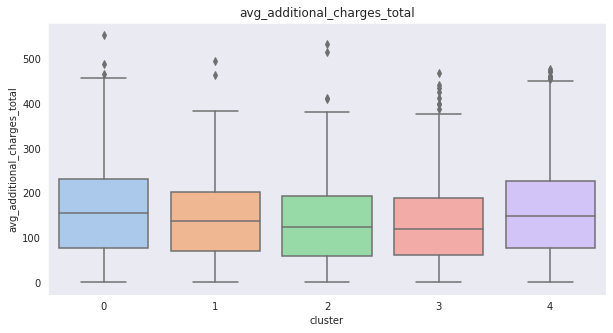

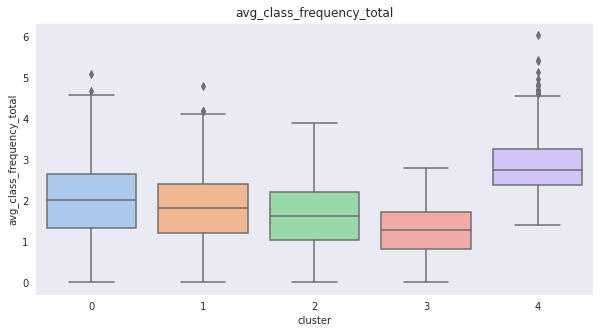

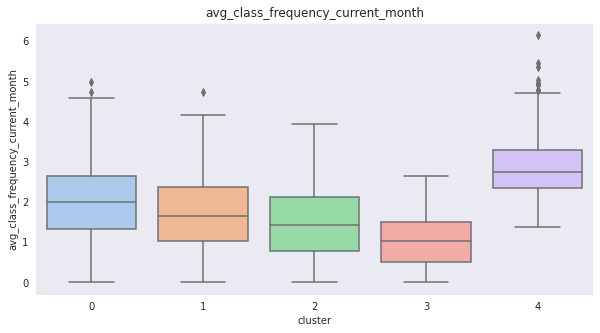

In [ ]:
for column in ['age', 'lifetime', 'avg_additional_charges_total', 'avg_class_frequency_total', \
               'avg_class_frequency_current_month']:
    plt.figure(figsize=(10,5))
    sns.boxplot(data = df, x = 'cluster', y = df[column])
    plt.title(column)
    plt.show()

### Для каждого полученного кластера посчитаем долю оттока

In [ ]:
df.groupby('cluster')['churn'].agg(['sum','count'])

,sum,count
cluster,,
0,28,1010
1,103,385
2,224,505
3,649,1262
4,57,838


In [ ]:
ratio = df.groupby('cluster')['churn'].agg('sum') / df.groupby('cluster')['churn'].agg('count')
ratio.sort_values(ascending=False)
# доля оттока для каждого кластера

cluster
3   0.51
2   0.44
1   0.27
4   0.07
0   0.03
Name: churn, dtype: float64

**Вывод:**

Еще раз убедились, что самые ненадежные кластеры это 3 и 2. Процент оттока составляет 51% и 44%

## Вывод и базовые рекомендации

В работе было выполнено следующее:

- Провели исследовательский анализ данных
   * Изучили средние значения и стандартные отклонения всех признаков
   * Посмотрели, как меняются средние значения для клиентов, кто ушел и остался.
   * Посторили графики
   * С помощью матрицы корреляций определили мультиколлинеарные признаки
   
   
- Сравнили две модели прогнозирования оттока клиентов - линейную регрессию и случайный лес. Случайный лес оказался предпочтительней. Для сравнения моделей использовали метрики accuracy, precision и recall.  


- Сделали кластеризацию клиентов
   * Получилось 5 кластеров
   * Максимальный процент оттока в двух и пяти кластеров и составляет 51 и 44 процента соответственно

Рекомендации: 
 
* В первую очередь стоит обратить внимание на длительность абонемента. Сделать какие-нибудь акции или промо-коды на абонементы. Предпочтительная длительность - 6 месяцев и более
* Рекламные акции для клиентов, живущих и работающих рядом с фитнес-центром
* Для удержания клиентов необходимо "заманивать" их на групповые занятия.
* Сделать акцент на людях, страше 30 и приглашать их в фитнес-центр